# Compute display LED intensities

In [1]:
import os
import re
import csv
import datetime
import numpy as np
import cv2
from PIL import Image
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
video_dir = 'videos'
frames_dir = 'video-frames'
image_dir = 'images'
data_dir = 'data'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

## Load fireplace video file and extract frames

In [3]:
filename = 'Fireplace 10 hours full HD.mp4'

vidcap = cv2.VideoCapture(os.path.join(video_dir, filename))
vidcap

<VideoCapture 0x1220b8eb0>

In [4]:
success, image = vidcap.read()
count = 0
print("Reading frames from video...")
while success and count < 1500:
    filename = f"frame{count:04d}.jpg"
    # save frame as JPEG file
    cv2.imwrite(os.path.join(frames_dir, filename), image)     
    success, image = vidcap.read()
    count += 1
print(f"{count} frame images saved to '{frames_dir}'.")

Reading frames from video...
1500 frame images saved to 'video-frames'.


## Load video frame images

In [5]:
filenames = sorted([name for name in os.listdir(frames_dir)
                    if name.startswith('frame')])
print(f"{len(filenames)} image files found")
filenames[:10]

1500 image files found


['frame0000.jpg',
 'frame0001.jpg',
 'frame0002.jpg',
 'frame0003.jpg',
 'frame0004.jpg',
 'frame0005.jpg',
 'frame0006.jpg',
 'frame0007.jpg',
 'frame0008.jpg',
 'frame0009.jpg']

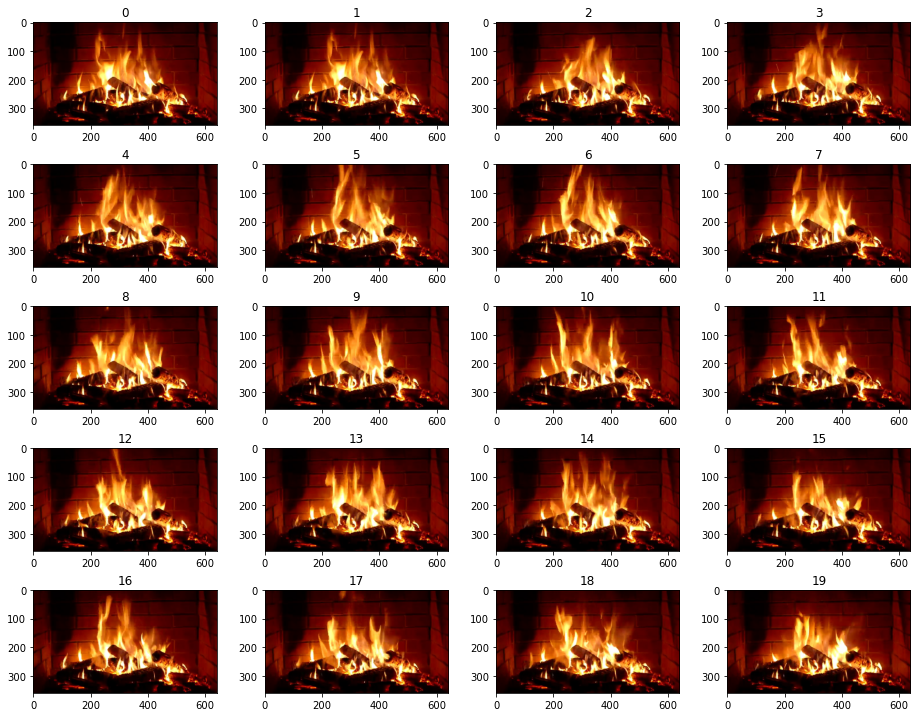

In [6]:
# Display selected images
selection = range(20)
fig, axes = plt.subplots(5, 4, figsize=(13, 10))
for i, img_id in enumerate(selection):
    ax = axes[i // 4, i % 4]
    img = Image.open(os.path.join(frames_dir, filenames[img_id]))
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

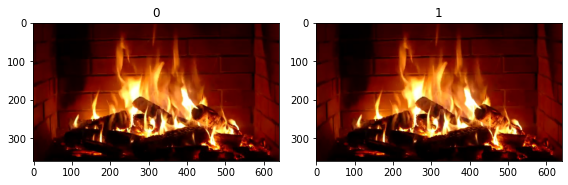

In [7]:
# Compare two frames
selection = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for i, img_id in enumerate(selection):
    ax = axes[i]
    img = Image.open(os.path.join(frames_dir, filenames[img_id]))
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

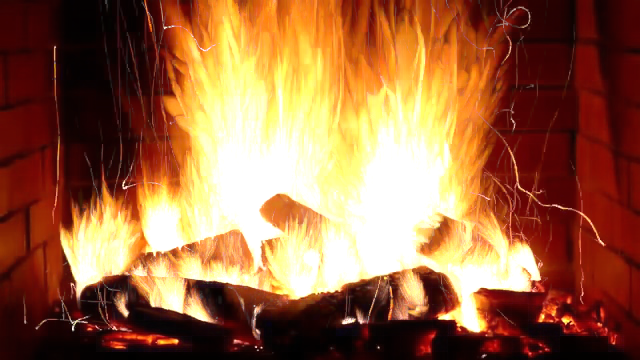

In [8]:
# Combine all frames into one image
img = Image.new('RGB', img.size)
img_data = np.array(img)
for filename in filenames:
    img = Image.open(os.path.join(frames_dir, filename))
    img_data = np.maximum(img_data, np.array(img))
combined_images = Image.fromarray(img_data)
combined_images.save(os.path.join(image_dir, f"combined_{len(filenames)}.jpg"))
combined_images

In [9]:
# Load mask images
images = []
size = None
for i in range(86):
    filename = f"im_{i:03d}.png"
    im = Image.open(os.path.join(image_dir, filename))
    if size is not None:
        assert(im.size == size)
    images.append(im)


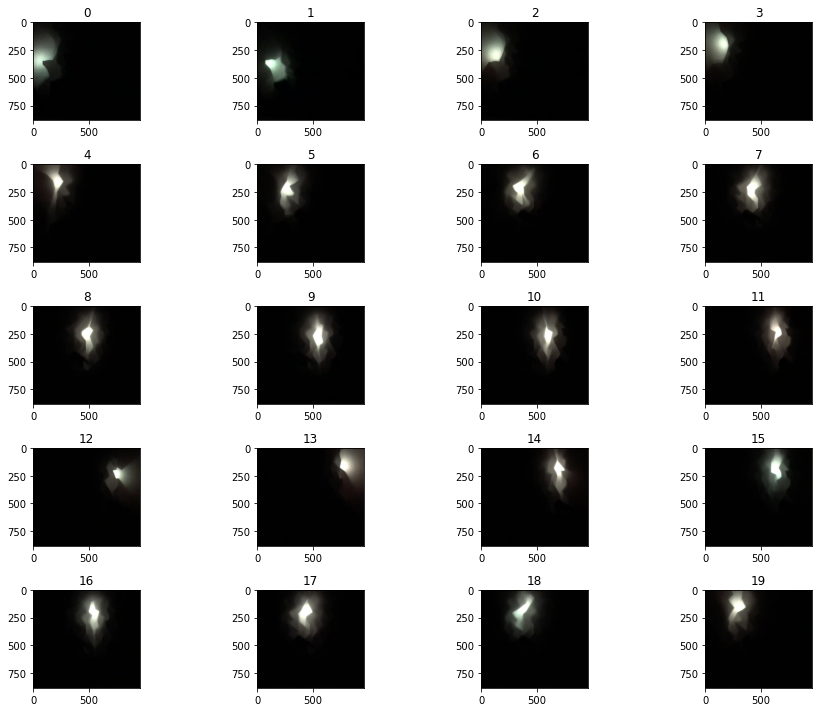

In [10]:
# Display selected mask images
selection = range(20)
fig, axes = plt.subplots(5, 4, figsize=(13, 10))
for i, img_id in enumerate(selection):
    ax = axes[i // 4, i % 4]
    img = images[img_id]
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

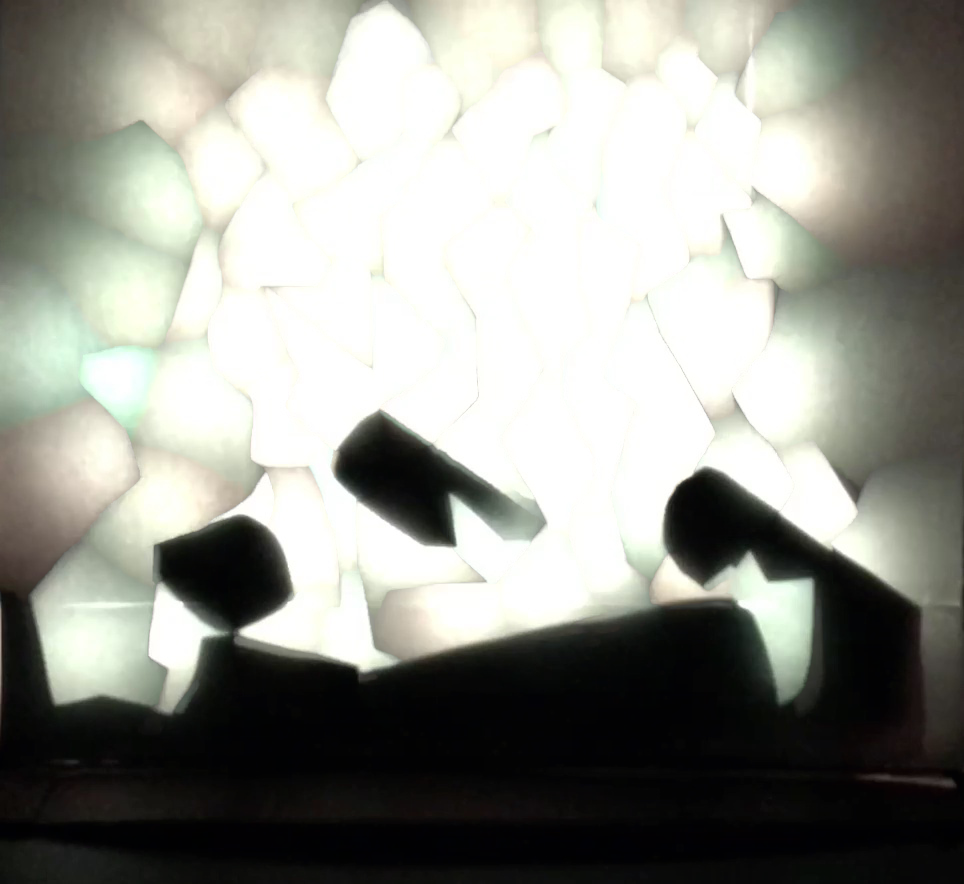

In [11]:
all_masks = Image.open(os.path.join(image_dir, "all_masks_86.png"))
all_masks

## Adjust mask images to match video frames

In [12]:
combined_images.size, all_masks.size

((640, 360), (964, 884))

(430, 347) (430, 347)


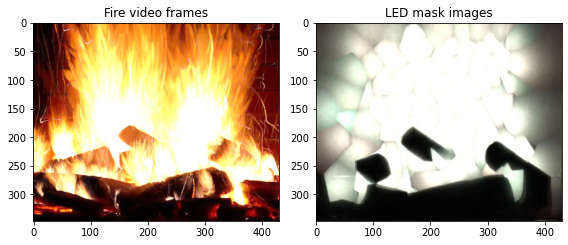

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

img_crop = [110, 13, 540, 360]
mask_crop = [0, 0, 964, 780]

combined_fire_adj = combined_images.crop(img_crop)
all_masks_adj = all_masks.crop(mask_crop)
mask_scale = combined_fire_adj.size[0] / all_masks_adj.size[0]
mask_resize = (np.array(all_masks_adj.size)*mask_scale).astype(int)
all_masks_adj = all_masks_adj.resize(mask_resize)
print(combined_fire_adj.size, all_masks_adj.size)

ax = axes[0]
ax.imshow(combined_fire_adj)
ax.set_title('Fire video frames')

ax = axes[1]
ax.imshow(all_masks_adj)
ax.set_title('LED mask images')

plt.tight_layout()
plt.savefig(os.path.join(image_dir, 'fig_combined_images.png'))
plt.show()

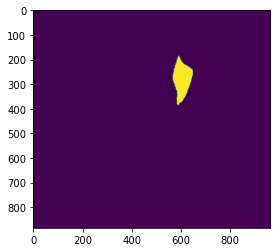

In [14]:
def im_mask(im, thresh=160):
    return (np.array(im) > thresh)[:, :, 0]

plt.imshow(im_mask(images[10]))
plt.show()

## Resize all mask images

In [15]:
# Save images
images = []
image_masks = []
for i in range(86):
    img = Image.open(os.path.join(image_dir, f"im_{i:03d}.png"))
    img_adj = img.crop(mask_crop).resize(mask_resize)
    img_adj.save(os.path.join(image_dir, f"im_{i:03d}_adj.png"))
    images.append(img_adj)
    image_masks.append(im_mask(img_adj))

## View individual masks

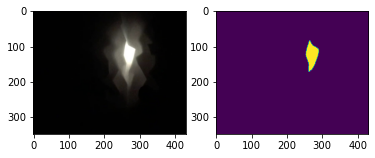

In [16]:
i = 10
img = images[i]
img_mask = Image.fromarray((image_masks[i]*255).astype('uint8'))

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_mask)
plt.show()

## Compute LED intensities to mimic video frame

(430, 347)


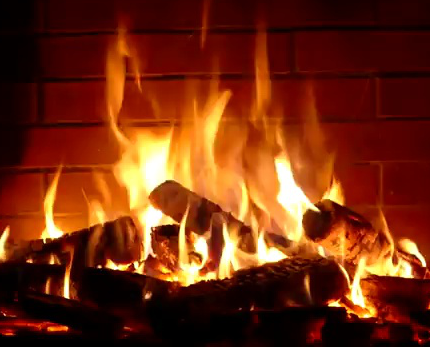

In [17]:
# Select a video frame (Note: 1st two frames are identical for some reason)
filename = filenames[1]
fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
print(fire_img.size)
fire_img

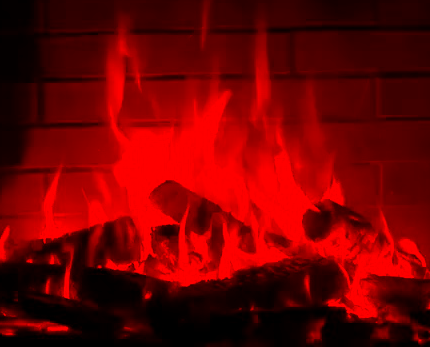

In [18]:
# RGB colours
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 1] = 0
fire_img_data[:, :, 2] = 0
Image.fromarray(fire_img_data)

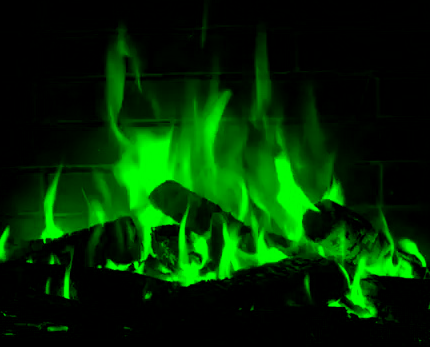

In [19]:
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 0] = 0
fire_img_data[:, :, 2] = 0
Image.fromarray(fire_img_data)

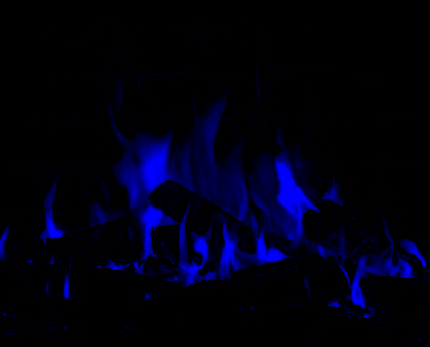

In [20]:
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 0] = 0
fire_img_data[:, :, 1] = 0
Image.fromarray(fire_img_data)

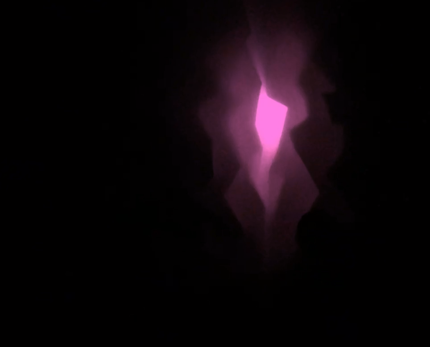

In [21]:
def filter_img_data(img_data, rgb):
    """Linearly adjust image intensities according to the
    rgb adjustment factors.
    """
    return np.clip(img_data.astype('float32') \
                   * np.array(rgb), 0, 255).astype('uint8')

mask_id = 10
mask_img_data = np.array(images[mask_id])

# RGB adjustment factors
rgb = [1, 0.5, 0.9]
                         
img_data_adj = filter_img_data(mask_img_data, rgb)
Image.fromarray(img_data_adj)

In [22]:
# Check masks and video frame images are same shape
fire_img_data.shape, mask_img_data.shape

((347, 430, 3), (347, 430, 3))

## Experiment 1 - compare one mask at a time

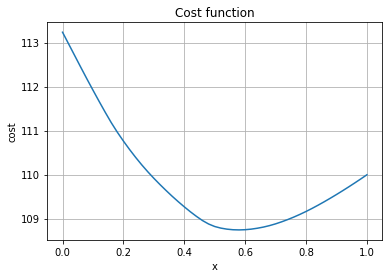

In [23]:
mask_id = 2
c = 0  # colour channel (r, g, b)
mask_img_data_c = np.array(images[mask_id])[:, :, c].astype('float32')

fire_img_data = np.array(fire_img)
fire_img_data_c = fire_img_data[:, :, c].astype('float32')

def cost_function(x):
    mask_img_data_adj = np.clip(mask_img_data_c * x, 0, 255)
    diff = np.abs(fire_img_data_c - mask_img_data_adj)
    return np.mean(diff)

x_values = np.linspace(0, 1, 51)
costs = []
for x in x_values:
    costs.append(cost_function(x))
plt.plot(x_values, costs)
plt.xlabel('x')
plt.ylabel('cost')
plt.title('Cost function')
plt.grid()
plt.show()

In [24]:
x0 = 1
res = minimize(cost_function, x0, bounds=[(0, 1)],
               options={'gtol': 1e-6})
print(res.message)
assert(res.status == 0)
x = res.x[0]
x

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


0.5789473698329792

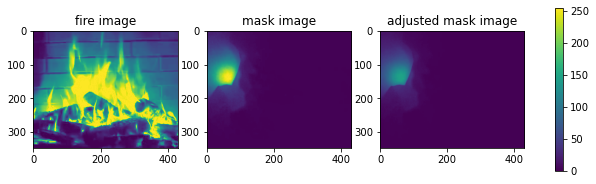

In [25]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

bool_mask = image_masks[mask_id]

img_data = np.zeros(bool_mask.shape)
img_data[bool_mask] = fire_img_data_c[bool_mask]
img1 = Image.fromarray(fire_img_data_c.astype('uint8'))

img2 = Image.fromarray(mask_img_data_c.astype('uint8'))

img3 = Image.fromarray(np.clip(mask_img_data_c * x, 0, 255).astype('uint8'))

fig, axes = plt.subplots(1, 3, figsize=(11, 3))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 255)
im = cm.ScalarMappable(norm=normalizer)
ax = axes[0]
ax.imshow(img1, vmin=0, vmax=255, cmap=cmap)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img2, vmin=0, vmax=255, cmap=cmap)
ax.set_title('mask image')
ax = axes[2]
ax.imshow(img3, vmin=0, vmax=255, cmap=cmap)
ax.set_title('adjusted mask image')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt.png'))
plt.show()

## Calculate all led intensities simultaneously

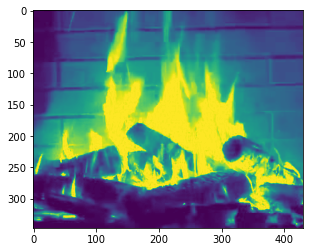

In [26]:
filename = filenames[7]
fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
fire_img_data = np.array(fire_img)

c = 0  # colour channel (r, g, b)
fire_img_data_c = fire_img_data[:, :, c]

plt.imshow(fire_img_data_c)
plt.show()

Cost function

$$J(x) = (A - B_1x_1 - B_2x_2 - ... - B_nx_n)^2$$

In [27]:
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])
img_mask_array.shape

(86, 347, 430)

In [28]:
img_mask_array.max()

255.0

In [29]:
img_mask_array.dtype

dtype('float64')

In [30]:
x = np.zeros(86)
x[-1] = 1
x.shape

(86,)

In [31]:
(x.reshape(-1, 1, 1) * img_mask_array).shape

(86, 347, 430)

In [32]:
combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
combined_mask_data.shape

(347, 430)

In [33]:
combined_mask_data.max()

255.0

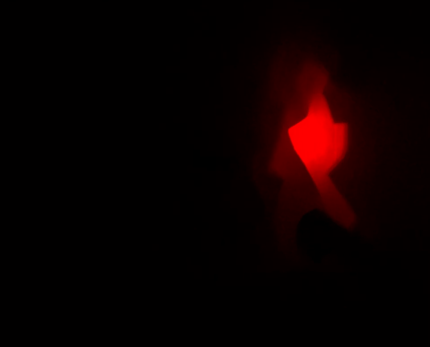

In [34]:
combined_img_data_uint8 = np.stack([
    np.clip(combined_mask_data, 0, 255), 
    np.zeros((347, 430)), 
    np.zeros((347, 430))
], axis=2).astype('uint8')

Image.fromarray(combined_img_data_uint8)

In [35]:
combined_mask_data.shape

(347, 430)

In [36]:
diff = (fire_img_data_c - combined_mask_data) ** 2
diff

array([[  1.,   1.,   9., ..., 900., 900., 900.],
       [  1.,   1.,   9., ..., 900., 900., 900.],
       [  1.,   1.,   9., ..., 900., 900., 900.],
       ...,
       [  1.,   1.,   1., ...,   4.,   1.,  36.],
       [  1.,   1.,   1., ...,   1.,   1.,  36.],
       [  1.,   1.,   1., ...,   1.,   9.,  36.]])

In [37]:
def cost_function(x):
    combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
    diff = (fire_img_data_c - combined_mask_data) ** 2
    return np.mean(diff)

x = np.random.rand(86)
cost_function(x)

6735.960430471131

In [38]:
%timeit cost_function(x)

53.8 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
# Solve using optimizer
x0 = np.random.rand(86)
res = minimize(cost_function, x0, method='Powell', 
               bounds=[(0, 1)]*86, tol=0.1)
print(res.message)
assert(res.status == 0)
x = res.x
x

Optimization terminated successfully.


array([0.06470554, 0.54440932, 0.38196601, 0.33281398, 0.32694432,
       0.27567864, 0.27568366, 0.57790327, 0.8874353 , 0.70820393,
       0.70820393, 0.73059869, 0.41529935, 0.34788405, 0.38196601,
       0.27568366, 0.54516324, 0.27568366, 0.43880262, 0.73059869,
       0.58470065, 0.23606798, 0.27547087, 0.06470554, 0.38196601,
       0.33882288, 0.34099784, 0.56274431, 0.47213595, 0.38196601,
       0.29754184, 0.20273464, 0.03433048, 0.20273464, 0.28944918,
       0.34179045, 0.44863268, 0.06470554, 0.20273464, 0.23606798,
       0.16759561, 0.1856741 , 0.04589803, 0.33390912, 0.85410197,
       0.70820393, 0.85410197, 0.65136733, 0.94316339, 0.94427191,
       0.55447696, 0.52250469, 0.94427191, 0.27568365, 0.82076863,
       0.79726536, 0.94316339, 0.65136732, 0.5505307 , 0.82076863,
       0.85673262, 0.7297029 , 0.94427191, 0.67376208, 0.65136733,
       0.82076863, 0.94316339, 0.94427191, 0.94427191, 0.65136732,
       0.68470066, 0.94427191, 0.33934578, 0.94427191, 0.94427

In [40]:
def construct_image_rgb(rgb, img_mask_array):
    rgb = np.clip(rgb, 0, 255)
    img_data = []
    for i in range(3):
        combined_mask_data = (rgb[:, i].reshape(-1, 1, 1) * img_mask_array).max(axis=0)
        img_data.append(combined_mask_data)
    combined_img_data_uint8 = np.stack(img_data, axis=2).astype('uint8')
    return Image.fromarray(combined_img_data_uint8)


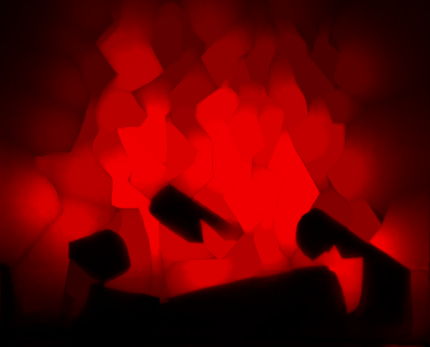

In [41]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 0] = x

construct_image_rgb(rgb, img_mask_array)

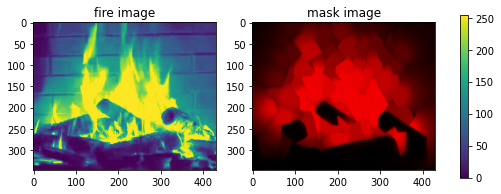

In [42]:
combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
combined_img_data_uint8 = np.stack([
    np.clip(combined_mask_data, 0, 255), 
    np.zeros((347, 430)), 
    np.zeros((347, 430))
], axis=2).astype('uint8')

img = Image.fromarray(combined_img_data_uint8)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 255)
im = cm.ScalarMappable(norm=normalizer)
ax = axes[0]
ax.imshow(fire_img_data_c, vmin=0, vmax=255, cmap=cmap)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img, vmin=0, vmax=255, cmap=cmap)
ax.set_title('mask image')

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()


In [43]:
def solve_mask_intensity_c1(target_image, img_mask_array, x0=None,
                            method='Powell', options=None):
    n = img_mask_array.shape[0]
    if x0 is None:
        x0 = 0.5*np.ones(n)

    def cost_function(x):
        combined_mask_data = (
            x.reshape(-1, 1, 1) * img_mask_array
        ).max(axis=0)
        diff = (target_image - combined_mask_data) ** 2
        return np.mean(diff)
    
    res = minimize(cost_function, x0, method=method, 
                   bounds=[(0, 1)]*86, tol=0.1, options=options)
    print(res.message)
    return res

# Example:
#x = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
#                            method='Powell', disp=True)

In [44]:
# Use previous solution as starting point
x0 = [ 0.06470554, 0.52786405, 0.38196601, 0.3291854 , 0.33083793,
       0.34234966, 0.57050849, 0.55836709, 0.8874353 , 0.67376208,
       0.70820393, 0.70664089, 0.41529935, 0.3480859 , 0.38196601,
       0.52786405, 0.53855738, 0.47213595, 0.47213595, 0.7169832 ,
       0.58207086, 0.23606798, 0.27544719, 0.06470554, 0.38196601,
       0.06470554, 0.23606798, 0.56695038, 0.43880262, 0.06470554,
       0.30218964, 0.20273464, 0.03802909, 0.23606798, 0.28663972,
       0.34195069, 0.42953714, 0.06470554, 0.20273464, 0.23606798,
       0.16940131, 0.03967538, 0.06470554, 0.3379184 , 0.85410197,
       0.70040974, 0.85410197, 0.65136733, 0.94316339, 0.94427191,
       0.55465419, 0.51972095, 0.94427191, 0.27568366, 0.79726536,
       0.81387248, 0.94316339, 0.65136732, 0.57772345, 0.79726536,
       0.85975178, 0.73059869, 0.94427191, 0.67376208, 0.61803399,
       0.82076863, 0.94316339, 0.94427191, 0.94427191, 0.65136732,
       0.72164121, 0.94427191, 0.33934579, 0.94427191, 0.94427191,
       0.85410197, 0.94427191, 0.71574452, 0.49398591, 0.69726535,
       0.93037568, 0.61803399, 0.94427191, 0.90983006, 0.85410197,
       0.67376208]

In [45]:
%%time

c = 0  # red
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
                            method='Powell', options=options)

print(res.x)
assert(res.status == 0)

r = res.x
r

Optimization terminated successfully.
         Current function value: 2818.737891
         Iterations: 1
         Function evaluations: 755
Optimization terminated successfully.
[0.00456767 0.53119738 0.39865516 0.34181054 0.339829   0.24134442
 0.24264579 0.55978981 0.88480889 0.70109542 0.73497383 0.70613779
 0.4115801  0.35883987 0.38595243 0.52889125 0.59638797 0.24264579
 0.44975559 0.72095529 0.57201598 0.23606798 0.25664421 0.24162906
 0.39414056 0.27314668 0.15247584 0.54259859 0.43459456 0.26673794
 0.29761465 0.19641933 0.11453025 0.21023201 0.26572068 0.24117298
 0.44272203 0.26131983 0.21105    0.24385377 0.14219446 0.06656709
 0.15655519 0.3316027  0.84505938 0.69316782 0.8574353  0.65043297
 0.98355766 0.99520272 0.56436339 0.52972788 0.99520272 0.24264579
 0.80134524 0.80660422 0.94762775 0.64354675 0.60204662 0.80807294
 0.84665898 0.74262411 0.98312389 0.65840577 0.65085125 0.8097858
 0.95555977 0.98084859 0.99520272 0.64697495 0.72323665 0.99520272
 0.24264579 0.9952

array([0.00456767, 0.53119738, 0.39865516, 0.34181054, 0.339829  ,
       0.24134442, 0.24264579, 0.55978981, 0.88480889, 0.70109542,
       0.73497383, 0.70613779, 0.4115801 , 0.35883987, 0.38595243,
       0.52889125, 0.59638797, 0.24264579, 0.44975559, 0.72095529,
       0.57201598, 0.23606798, 0.25664421, 0.24162906, 0.39414056,
       0.27314668, 0.15247584, 0.54259859, 0.43459456, 0.26673794,
       0.29761465, 0.19641933, 0.11453025, 0.21023201, 0.26572068,
       0.24117298, 0.44272203, 0.26131983, 0.21105   , 0.24385377,
       0.14219446, 0.06656709, 0.15655519, 0.3316027 , 0.84505938,
       0.69316782, 0.8574353 , 0.65043297, 0.98355766, 0.99520272,
       0.56436339, 0.52972788, 0.99520272, 0.24264579, 0.80134524,
       0.80660422, 0.94762775, 0.64354675, 0.60204662, 0.80807294,
       0.84665898, 0.74262411, 0.98312389, 0.65840577, 0.65085125,
       0.8097858 , 0.95555977, 0.98084859, 0.99520272, 0.64697495,
       0.72323665, 0.99520272, 0.24264579, 0.99520272, 0.97449

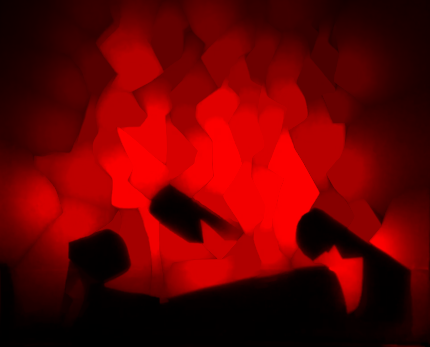

In [46]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 0] = r

construct_image_rgb(rgb, img_mask_array)

In [47]:
%%time

c = 1  # green
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x,
                            method='Powell', options=options)

g = res.x
g

Optimization terminated successfully.
         Current function value: 2087.225918
         Iterations: 3
         Function evaluations: 2596
Optimization terminated successfully.
CPU times: user 2min 1s, sys: 17.2 s, total: 2min 19s
Wall time: 2min 19s


array([0.00583917, 0.04840151, 0.00344271, 0.00364372, 0.00484494,
       0.33460706, 0.00622463, 0.11620652, 0.44548291, 0.2801293 ,
       0.2294013 , 0.00338815, 0.00534885, 0.00548455, 0.00408445,
       0.05719745, 0.11607851, 0.06683425, 0.05137739, 0.05393261,
       0.02739911, 0.00386723, 0.00428818, 0.0058919 , 0.00397482,
       0.00573688, 0.00494702, 0.0484438 , 0.00649685, 0.00589351,
       0.00425605, 0.00442884, 0.00550014, 0.00437735, 0.0053989 ,
       0.05122456, 0.06959607, 0.00578686, 0.00518939, 0.00339303,
       0.0700667 , 0.00395872, 0.00624702, 0.16549221, 0.59333844,
       0.48584218, 0.69767938, 0.09476083, 0.53500718, 0.31286433,
       0.10407092, 0.12587208, 0.5344026 , 0.24134508, 0.44929018,
       0.40599469, 0.72595331, 0.24606798, 0.07255645, 0.40774944,
       0.27105737, 0.09423489, 0.67090429, 0.24264579, 0.68135207,
       0.24172474, 0.70332574, 0.7747963 , 0.91781624, 0.03173211,
       0.10358141, 0.91316339, 0.24134509, 0.79070442, 0.25351

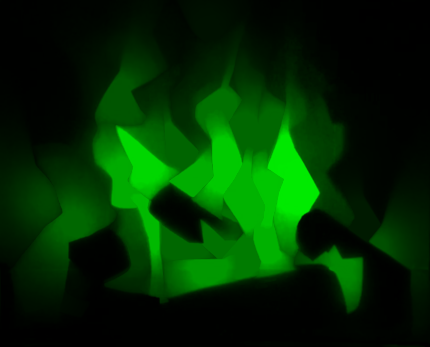

In [48]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 1] = g

construct_image_rgb(rgb, img_mask_array)

In [49]:
%%time

c = 2  # blue
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
                            method='Powell', options=options)

print(res.x)
assert(res.status == 0)

b = res.x
b

Optimization terminated successfully.
         Current function value: 1125.318561
         Iterations: 3
         Function evaluations: 2683
Optimization terminated successfully.
[0.00373083 0.00587196 0.00505062 0.00648895 0.00559094 0.00567051
 0.0054933  0.00574698 0.07386976 0.00540747 0.06476643 0.05309929
 0.00483081 0.00442884 0.004202   0.03279542 0.07090652 0.00657644
 0.00555    0.0042212  0.00962619 0.00438469 0.00658918 0.00759633
 0.00432253 0.0042024  0.00586445 0.00620631 0.0047355  0.00650684
 0.00612206 0.00442884 0.00442884 0.00452119 0.00346032 0.00634421
 0.00545841 0.0057579  0.00629942 0.00537217 0.0554981  0.00632202
 0.0340621  0.0868986  0.35586033 0.27617598 0.64198864 0.05639226
 0.2786677  0.14699913 0.01126837 0.05700271 0.31943584 0.2971421
 0.23940131 0.18561569 0.42186053 0.12493062 0.00603783 0.14101592
 0.07491752 0.00464549 0.31051137 0.13832159 0.26920939 0.12525334
 0.12694545 0.10812071 0.5604584  0.00515904 0.03584381 0.07569446
 0.10403708 0.291

array([0.00373083, 0.00587196, 0.00505062, 0.00648895, 0.00559094,
       0.00567051, 0.0054933 , 0.00574698, 0.07386976, 0.00540747,
       0.06476643, 0.05309929, 0.00483081, 0.00442884, 0.004202  ,
       0.03279542, 0.07090652, 0.00657644, 0.00555   , 0.0042212 ,
       0.00962619, 0.00438469, 0.00658918, 0.00759633, 0.00432253,
       0.0042024 , 0.00586445, 0.00620631, 0.0047355 , 0.00650684,
       0.00612206, 0.00442884, 0.00442884, 0.00452119, 0.00346032,
       0.00634421, 0.00545841, 0.0057579 , 0.00629942, 0.00537217,
       0.0554981 , 0.00632202, 0.0340621 , 0.0868986 , 0.35586033,
       0.27617598, 0.64198864, 0.05639226, 0.2786677 , 0.14699913,
       0.01126837, 0.05700271, 0.31943584, 0.2971421 , 0.23940131,
       0.18561569, 0.42186053, 0.12493062, 0.00603783, 0.14101592,
       0.07491752, 0.00464549, 0.31051137, 0.13832159, 0.26920939,
       0.12525334, 0.12694545, 0.10812071, 0.5604584 , 0.00515904,
       0.03584381, 0.07569446, 0.10403708, 0.29102165, 0.00342

In [50]:
# Cost function each iteration
for x in res.allvecs:
    print(cost_function(x))

11167.138324693868
1864.8699862253118
1185.3494821791203
1125.318560770701


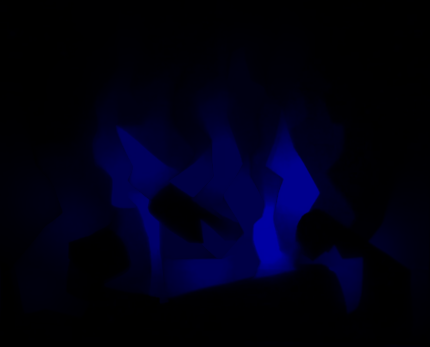

In [51]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 2] = b

construct_image_rgb(rgb, img_mask_array)

## Show RGB LED intensities

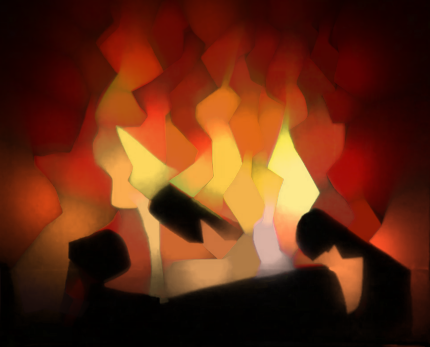

In [52]:
rgb = np.vstack([r, g, b]).T
img = construct_image_rgb(rgb, img_mask_array)
img.save(os.path.join(image_dir, 'reconstructed_image.png'))
img

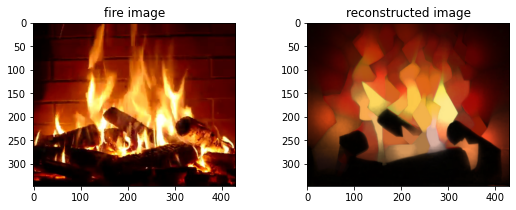

In [53]:
img = construct_image_rgb(rgb, img_mask_array)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

ax = axes[0]
ax.imshow(fire_img_data)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img)
ax.set_title('reconstructed image')

plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt.png'))
plt.show()

## Automated calculation of sequence of frames

<font color='red'>Warning: This takes a long time!

In [58]:
# Combine process to compute RGB intensities for whole image

def solve_mask_intensity_rgb(target_image, img_mask_array, rgb0=None,
                             method='Powell', options=None):
    if options is None:
        options = {'xtol': 0.01, 'disp': True, 'return_all': True}

    rgb = []
    results = []
    for c in range(3):
        print(f"\nStarting minimization for '{['r', 'g', 'b'][c]}' channel...")
        target_image_c = target_image[:, :, c]
        img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])
        x0 = rgb0[c]
        res = solve_mask_intensity_c1(target_image_c, img_mask_array, x0=x0,
                                      method=method, options=options)
        print(res.message)
        print(res.x)
        assert(res.status == 0)
        rgb.append(res.x)
        results.append(res)
    
    return rgb, results



In [59]:
def save_rgb_seq_data(seq_no, rgb, label='seq_data'):
    dt_string = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
    filename = f'{label}_ids.csv'
    with open(os.path.join(data_dir, filename), 'a') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow([dt_string, seq_no])
    for c in range(3):
        filename = f'{label}_rgb_{c}.csv'
        with open(os.path.join(data_dir, filename), 'a') as f:
            data = rgb[c].reshape(1, -1)
            np.savetxt(f, data, '%.3f', ',')

In [60]:
# Initial values for optimizer
rgb0 = [
    np.array([0.247, 0.536, 0.389, 0.322, 0.322, 0.241, 0.818, 0.389, 0.764,
        0.633, 0.599, 0.69 , 0.471, 0.359, 0.47 , 0.243, 0.476, 0.712,
        0.243, 0.482, 0.241, 0.225, 0.246, 0.297, 0.857, 0.644, 0.546,
        0.553, 0.364, 0.329, 0.306, 0.196, 0.006, 0.182, 0.239, 0.241,
        0.455, 0.372, 0.208, 0.229, 0.159, 0.239, 0.181, 0.347, 0.841,
        0.758, 0.87 , 0.695, 0.995, 0.995, 0.599, 0.552, 0.995, 0.243,
        0.885, 0.845, 0.965, 0.638, 0.431, 0.851, 0.877, 0.731, 0.86 ,
        0.88 , 0.67 , 0.581, 0.954, 0.994, 0.984, 0.674, 0.656, 0.938,
        0.959, 0.995, 0.995, 0.829, 0.64 , 0.243, 0.371, 0.544, 0.9  ,
        0.746, 0.995, 0.649, 0.822, 0.637]),
     np.array([0.006, 0.061, 0.004, 0.015, 0.017, 0.089, 0.414, 0.27 , 0.147,
        0.1  , 0.164, 0.258, 0.004, 0.005, 0.062, 0.068, 0.086, 0.27 ,
        0.145, 0.054, 0.005, 0.004, 0.003, 0.029, 0.341, 0.152, 0.111,
        0.049, 0.035, 0.035, 0.005, 0.004, 0.005, 0.006, 0.004, 0.038,
        0.006, 0.006, 0.006, 0.006, 0.085, 0.075, 0.006, 0.159, 0.603,
        0.547, 0.739, 0.005, 0.64 , 0.393, 0.155, 0.119, 0.776, 0.631,
        0.49 , 0.471, 0.723, 0.223, 0.057, 0.46 , 0.304, 0.105, 0.306,
        0.376, 0.395, 0.338, 0.242, 0.767, 0.888, 0.004, 0.1  , 0.241,
        0.604, 0.599, 0.629, 0.382, 0.518, 0.097, 0.006, 0.088, 0.525,
        0.273, 0.539, 0.127, 0.32 , 0.174]),
     np.array([0.007, 0.005, 0.004, 0.005, 0.005, 0.004, 0.122, 0.028, 0.044,
        0.039, 0.055, 0.006, 0.005, 0.004, 0.005, 0.028, 0.026, 0.005,
        0.038, 0.004, 0.005, 0.004, 0.006, 0.003, 0.057, 0.005, 0.004,
        0.004, 0.006, 0.003, 0.006, 0.004, 0.005, 0.005, 0.004, 0.004,
        0.005, 0.004, 0.005, 0.004, 0.037, 0.044, 0.039, 0.078, 0.346,
        0.293, 0.576, 0.006, 0.402, 0.166, 0.005, 0.045, 0.389, 0.255,
        0.236, 0.205, 0.389, 0.039, 0.031, 0.155, 0.091, 0.005, 0.105,
        0.068, 0.233, 0.074, 0.006, 0.099, 0.446, 0.005, 0.006, 0.004,
        0.004, 0.189, 0.117, 0.039, 0.152, 0.005, 0.006, 0.028, 0.15 ,
        0.047, 0.11 , 0.006, 0.005, 0.006])
]

In [61]:
%%time

results_record = []

for seq_no in range(50, 151):
    filename = filenames[seq_no]
    
    print(f"\nStarting image {seq_no} from file '{filename}'")
    fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
    fire_img_data = np.array(fire_img)

    rgb, results = solve_mask_intensity_rgb(fire_img_data, 
                                            img_mask_array,
                                            rgb0=rgb0)
    results_record.append((rgb, results))
    
    save_rgb_seq_data(seq_no, rgb)
    
    # Use current solution for next initial condition
    rgb0 = rgb
    


Starting image 50 from file 'frame0050.jpg'

Starting minimization for 'r' channel...
Optimization terminated successfully.
         Current function value: 3094.631955
         Iterations: 2
         Function evaluations: 1489
Optimization terminated successfully.
Optimization terminated successfully.
[0.23960736 0.56085454 0.43645496 0.39227722 0.33905789 0.70828452
 0.63526338 0.78646789 0.78732439 0.24264579 0.48872093 0.38196601
 0.3356967  0.32566913 0.31107004 0.28795082 0.44683367 0.66652488
 0.24264579 0.4645619  0.2398451  0.25180222 0.23940131 0.29003503
 0.33879686 0.32224737 0.53643238 0.61803399 0.30344468 0.25399674
 0.26694501 0.1827234  0.12929075 0.20673015 0.13957889 0.24126237
 0.47365683 0.24261272 0.19501787 0.2083789  0.14491113 0.24193489
 0.15172756 0.35070868 0.90800439 0.75673824 0.87710713 0.64367052
 0.99520271 0.99520271 0.56307148 0.5080161  0.99520271 0.77690188
 0.77773391 0.87595164 0.96865632 0.68735145 0.64545288 0.80623386
 0.89862402 0.8459571  0.

Optimization terminated successfully.
         Current function value: 2185.658531
         Iterations: 2
         Function evaluations: 1799
Optimization terminated successfully.
Optimization terminated successfully.
[0.02415791 0.00645079 0.00599554 0.00514101 0.00469684 0.27065226
 0.0904527  0.0045189  0.11523798 0.11047091 0.07043946 0.00651233
 0.00596749 0.00442884 0.00472645 0.00387593 0.05143155 0.08432128
 0.08071637 0.00425289 0.03641114 0.0063966  0.00659328 0.00642798
 0.00338259 0.00369287 0.04885858 0.00387141 0.00609448 0.00534074
 0.00561767 0.00442884 0.00442884 0.00465997 0.00450689 0.00482657
 0.00423957 0.00409419 0.00528741 0.00569807 0.07517365 0.09061467
 0.00649681 0.16534976 0.68010373 0.38617977 0.66711419 0.14931891
 0.68872888 0.24224645 0.09480937 0.40066416 0.83564827 0.20156594
 0.46226089 0.54405995 0.68913548 0.25310798 0.08020134 0.43046608
 0.34115032 0.12537925 0.27741626 0.67547934 0.24264579 0.32908801
 0.67104345 0.73077031 0.57321545 0.00361867 

Optimization terminated successfully.
         Current function value: 1248.264156
         Iterations: 1
         Function evaluations: 889
Optimization terminated successfully.
Optimization terminated successfully.
[0.00624307 0.00493447 0.00634108 0.00442884 0.00351043 0.00367445
 0.03186959 0.00346444 0.04696518 0.17648771 0.00381161 0.00564247
 0.00500976 0.00442884 0.00583825 0.00341755 0.05759843 0.02922608
 0.00365537 0.00444974 0.0040061  0.00442884 0.0035951  0.00367926
 0.00722132 0.00433583 0.00380207 0.00433209 0.00560908 0.00570937
 0.00442884 0.00442884 0.00442884 0.00354974 0.00390779 0.00542489
 0.00417882 0.00405524 0.0041707  0.00347508 0.04234513 0.04563197
 0.03557087 0.08087567 0.36749524 0.20778303 0.51413148 0.05825622
 0.39929858 0.17341361 0.02904698 0.00554784 0.56766944 0.31700212
 0.21326333 0.20841214 0.36950104 0.11748331 0.02759276 0.14121854
 0.08288752 0.027993   0.08914315 0.00620436 0.46094614 0.1133727
 0.13797161 0.55383151 0.56072401 0.00561188 0.

Optimization terminated successfully.
         Current function value: 2995.319516
         Iterations: 1
         Function evaluations: 728
Optimization terminated successfully.
Optimization terminated successfully.
[0.00433806 0.48178145 0.3663136  0.32637039 0.34203538 0.24134504
 0.85983316 0.9784238  0.86076863 0.51808332 0.24264579 0.71366637
 0.37813277 0.35321225 0.44703612 0.24264579 0.49373321 0.91856475
 0.84927079 0.80327941 0.76393202 0.24599133 0.25784112 0.42635671
 0.65127144 0.63932023 0.74179493 0.24264579 0.38529934 0.28207132
 0.29720079 0.19680002 0.128032   0.25829886 0.24171581 0.43600906
 0.63831161 0.24264579 0.25092235 0.23606798 0.11673883 0.3407925
 0.15517759 0.3213343  0.89837895 0.79755957 0.87161653 0.54183453
 0.99520271 0.99520271 0.54391847 0.48625304 0.98684438 0.24264579
 0.83937379 0.73861201 0.89348931 0.59200647 0.23273464 0.74791506
 0.7733009  0.75726535 0.83629895 0.96094446 0.71277333 0.60297399
 0.92854611 0.94576203 0.97050723 0.64286046 0.

Optimization terminated successfully.
         Current function value: 2259.114934
         Iterations: 1
         Function evaluations: 874
Optimization terminated successfully.
Optimization terminated successfully.
[0.01657611 0.00615041 0.01088522 0.00381658 0.0062776  0.00336095
 0.47885331 0.3776096  0.12962936 0.00448063 0.059025   0.30816113
 0.00334314 0.00354597 0.12949324 0.08593908 0.06466578 0.29137742
 0.3079017  0.23980883 0.00344331 0.00522121 0.00345524 0.0047568
 0.16438701 0.08270882 0.25715264 0.06397976 0.00516807 0.00353333
 0.00636814 0.00348886 0.0037105  0.00450917 0.0066077  0.04741309
 0.04367144 0.02886807 0.00647938 0.00376759 0.07829736 0.13581169
 0.00647158 0.16535203 0.63578715 0.56302474 0.79453024 0.00336971
 0.57881167 0.3155249  0.15970394 0.22308113 0.84726631 0.66169775
 0.42679682 0.55457907 0.78352838 0.23606798 0.08045782 0.41646772
 0.32867253 0.0746358  0.4376941  0.75615076 0.2413387  0.20979924
 0.51830615 0.73204153 0.24264579 0.00442899 0.

Optimization terminated successfully.
         Current function value: 1121.974221
         Iterations: 1
         Function evaluations: 922
Optimization terminated successfully.
Optimization terminated successfully.
[0.0052485  0.00522189 0.00553712 0.00442884 0.00503152 0.06926354
 0.00533835 0.0050197  0.050686   0.00550469 0.00387877 0.00452842
 0.00369648 0.00442884 0.00611041 0.00459066 0.00605032 0.00533044
 0.00630576 0.01325354 0.0049586  0.00442884 0.00395329 0.0047803
 0.00437418 0.00462836 0.00441581 0.00982623 0.0052572  0.00442253
 0.00442884 0.00442884 0.00442884 0.00358739 0.00638866 0.00562784
 0.00561218 0.00623772 0.00458531 0.00442884 0.00435572 0.09343057
 0.00561375 0.12054809 0.37286676 0.16987264 0.55115123 0.0460043
 0.3533911  0.20977667 0.00641994 0.03139645 0.5128005  0.22837931
 0.21457933 0.25364146 0.50017621 0.00592302 0.05583362 0.10397776
 0.00544588 0.02021528 0.21946802 0.33174577 0.23606798 0.00462333
 0.00589538 0.40935233 0.08149709 0.00499236 0.0

Optimization terminated successfully.
         Current function value: 2794.912423
         Iterations: 1
         Function evaluations: 738
Optimization terminated successfully.
Optimization terminated successfully.
[0.24627507 0.49771287 0.4029121  0.34044388 0.35542771 0.24134506
 0.44102744 0.24264579 0.64421474 0.8014235  0.61803399 0.58313203
 0.41001368 0.35405738 0.33568666 0.29945818 0.24264579 0.42359567
 0.42403894 0.39099406 0.29146952 0.2398774  0.23606798 0.29597527
 0.31170055 0.2540607  0.15083804 0.35381101 0.33438819 0.26253162
 0.2936153  0.19433208 0.12875387 0.21655348 0.15068681 0.25551152
 0.27379402 0.22940131 0.21151628 0.22906577 0.14283721 0.30911148
 0.16055151 0.31395715 0.87514284 0.68118639 0.89566169 0.56674232
 0.99520271 0.99520271 0.65617264 0.52196469 0.99520272 0.24264579
 0.71319648 0.7250686  0.87194168 0.59644863 0.57199071 0.80576077
 0.76393202 0.77302898 0.99520271 0.70349452 0.72392125 0.24264579
 0.95100421 0.92182731 0.98942732 0.65107441 0

Optimization terminated successfully.
         Current function value: 2488.715575
         Iterations: 1
         Function evaluations: 901
Optimization terminated successfully.
Optimization terminated successfully.
[0.00470293 0.04959839 0.01275816 0.0065761  0.005385   0.54003158
 0.54181669 0.00407705 0.11677128 0.07163599 0.38563971 0.0063904
 0.00543315 0.00336733 0.00476253 0.05068571 0.06918799 0.08518224
 0.14699052 0.50475213 0.14890524 0.00338484 0.0051146  0.07924097
 0.00625991 0.05434972 0.08595438 0.03836168 0.00426025 0.00512821
 0.00612667 0.00442884 0.00662104 0.00417192 0.00631627 0.00659711
 0.00360585 0.00402383 0.00530558 0.00666575 0.00417077 0.16674009
 0.00491651 0.15786926 0.61075767 0.49056681 0.81081552 0.25207301
 0.56928614 0.32522807 0.08936603 0.11600478 0.82181068 0.24006337
 0.38196601 0.4686895  0.77059869 0.08551655 0.00559453 0.37863268
 0.26397849 0.0911116  0.24099635 0.64808268 0.72243663 0.14727752
 0.77198786 0.77079009 0.70820393 0.02796145 0.

Optimization terminated successfully.
         Current function value: 1163.395637
         Iterations: 1
         Function evaluations: 873
Optimization terminated successfully.
Optimization terminated successfully.
[0.00438178 0.00414697 0.00426504 0.00442884 0.00474179 0.11894597
 0.02360609 0.02065252 0.03294836 0.00646935 0.00632593 0.05545948
 0.00409295 0.00442884 0.00555895 0.02448186 0.00613886 0.00630415
 0.00661031 0.0051797  0.00627061 0.0058363  0.00425382 0.00641239
 0.00474812 0.00426007 0.00542227 0.0037448  0.00372576 0.006288
 0.00442884 0.00442884 0.00442884 0.00364991 0.00622591 0.00655416
 0.0046287  0.00473916 0.00517967 0.00442884 0.00730181 0.07220667
 0.03786664 0.08381862 0.34322092 0.28960856 0.48819876 0.04625838
 0.24830471 0.21095199 0.00527202 0.04129383 0.60484647 0.24898028
 0.2086309  0.19085598 0.38541045 0.11464748 0.04524557 0.14568483
 0.08130957 0.02861121 0.0743617  0.12442507 0.26151157 0.11675487
 0.08622528 0.38196601 0.32747962 0.00416629 0.0

Optimization terminated successfully.
         Current function value: 2922.187423
         Iterations: 1
         Function evaluations: 748
Optimization terminated successfully.
Optimization terminated successfully.
[0.24611193 0.49945195 0.39072946 0.32922396 0.35711287 0.84731061
 0.75148878 0.72104076 0.44751638 0.51592873 0.24264579 0.47213595
 0.35435686 0.33964316 0.33396272 0.37863268 0.33192188 0.24264579
 0.39032435 0.34827677 0.24221043 0.2240802  0.22896598 0.24942937
 0.36139021 0.25140481 0.14130082 0.44128391 0.29581244 0.32516549
 0.26904054 0.18528206 0.12964478 0.2005039  0.21405467 0.24074082
 0.28695119 0.14207679 0.17933648 0.2120357  0.11345164 0.27425798
 0.11698766 0.32638529 0.87068474 0.68152201 0.87997498 0.68870522
 0.99520271 0.99520271 0.61274349 0.56124687 0.99520271 0.24264579
 0.89211679 0.72799055 0.93966528 0.65392553 0.42923614 0.78472927
 0.78472241 0.72151487 0.99520272 0.65706712 0.64514066 0.82878492
 0.96353288 0.97751333 0.79123978 0.71541684 0

Optimization terminated successfully.
         Current function value: 2344.721640
         Iterations: 1
         Function evaluations: 924
Optimization terminated successfully.
Optimization terminated successfully.
[0.00396193 0.05648568 0.00449029 0.00574497 0.00407311 0.35115451
 0.06566383 0.00586208 0.00376285 0.06121103 0.04948705 0.00544303
 0.00392317 0.00442884 0.00368096 0.0062757  0.04092959 0.06156713
 0.00608562 0.00359137 0.00547834 0.00601943 0.0038333  0.0053417
 0.00483172 0.00658526 0.03834627 0.00409398 0.00508213 0.00361543
 0.00492361 0.00442884 0.00442884 0.00451014 0.00407654 0.00652022
 0.00462398 0.00596641 0.00380111 0.00476924 0.08199303 0.10098763
 0.00660931 0.15728644 0.6578805  0.24880213 0.75088797 0.12283462
 0.62136732 0.33768246 0.17615351 0.27326427 0.44484523 0.68649842
 0.34461456 0.44951047 0.804237   0.27348167 0.08823863 0.38848356
 0.23606798 0.0718864  0.40460166 0.24264579 0.6106915  0.3957766
 0.24984092 0.47546929 0.8488884  0.02831507 0.0

Optimization terminated successfully.
         Current function value: 1238.011562
         Iterations: 1
         Function evaluations: 885
Optimization terminated successfully.
Optimization terminated successfully.
[0.0042146  0.00617148 0.00432167 0.00359735 0.00637674 0.01504064
 0.00644265 0.0034606  0.0048858  0.00558012 0.02901804 0.00502679
 0.00394792 0.00442884 0.00494873 0.00636983 0.0065906  0.00630747
 0.00449634 0.00440415 0.00417731 0.00442884 0.00442884 0.00459933
 0.00334083 0.00442884 0.00343238 0.00605351 0.00482567 0.00654579
 0.00540842 0.00607051 0.00442884 0.00563214 0.00514304 0.00537404
 0.00414283 0.00442884 0.00428314 0.00354858 0.04398653 0.07181048
 0.00370187 0.09928096 0.35038082 0.2830213  0.53196149 0.05965001
 0.32851981 0.16213763 0.02640815 0.05872043 0.25731031 0.24924031
 0.2521528  0.24278025 0.4508447  0.04393424 0.02992301 0.19349821
 0.03655825 0.03498219 0.31353938 0.18855278 0.23606798 0.25561175
 0.00370275 0.11839304 0.47230173 0.00340462 0

Optimization terminated successfully.
         Current function value: 2941.504236
         Iterations: 1
         Function evaluations: 748
Optimization terminated successfully.
Optimization terminated successfully.
[0.24163295 0.24264579 0.39766985 0.32704735 0.30717748 0.54271404
 0.79351689 0.24264579 0.24264579 0.49342219 0.24264579 0.52763374
 0.41925581 0.33633957 0.44062185 0.27291528 0.33610171 0.42187602
 0.24264579 0.47448623 0.23981017 0.22281822 0.21825094 0.25827995
 0.32456246 0.23606798 0.15059977 0.31838066 0.33467889 0.25021684
 0.36021268 0.17796173 0.09990324 0.17519782 0.21699602 0.14726194
 0.25477923 0.2072407  0.18172235 0.24085833 0.13284861 0.26670836
 0.15240224 0.33321869 0.89018688 0.69380112 0.85042745 0.09674775
 0.99202751 0.99520271 0.57444826 0.50271522 0.99188338 0.24264579
 0.78530389 0.88102017 0.88803474 0.61803399 0.37487884 0.75626593
 0.88010114 0.89753322 0.96390412 0.77095911 0.73188839 0.24264579
 0.92256633 0.98702032 0.89187715 0.66451136 0

Optimization terminated successfully.
         Current function value: 2335.767394
         Iterations: 2
         Function evaluations: 1765
Optimization terminated successfully.
Optimization terminated successfully.
[0.00533964 0.00630004 0.03426313 0.0423077  0.2882058  0.24070574
 0.14665377 0.39596303 0.13205563 0.08633013 0.06921654 0.04105358
 0.00382084 0.00442884 0.00493849 0.00344063 0.06775434 0.25151704
 0.13367246 0.18986524 0.06304146 0.02773446 0.00356981 0.06031695
 0.05645908 0.04977762 0.17023941 0.00411715 0.00455869 0.00421737
 0.0054353  0.00442884 0.00648895 0.00491581 0.00548207 0.04145931
 0.03345652 0.02609459 0.00573797 0.00469591 0.08281017 0.09567295
 0.07624386 0.15597782 0.64690375 0.53351477 0.72566306 0.1407971
 0.64820193 0.32860537 0.11655902 0.48827581 0.53453072 0.19999998
 0.44187982 0.45081276 0.73672439 0.24894081 0.08055332 0.45156634
 0.27779859 0.12769457 0.59135719 0.71153727 0.24264579 0.43314695
 0.73413533 0.24134464 0.93944253 0.00471647 0

Optimization terminated successfully.
         Current function value: 1091.202044
         Iterations: 1
         Function evaluations: 888
Optimization terminated successfully.
Optimization terminated successfully.
[0.00646363 0.00559428 0.00460736 0.00502653 0.00486656 0.00491986
 0.00349436 0.08050049 0.04380103 0.00649539 0.0278686  0.00525127
 0.00442884 0.00442884 0.00434718 0.00841764 0.00603343 0.0816313
 0.00610672 0.00416236 0.00358898 0.00442884 0.00442884 0.00407255
 0.00611317 0.00380768 0.00559989 0.00546954 0.00453026 0.00336012
 0.00411344 0.00442884 0.00442884 0.00388444 0.00428321 0.00388648
 0.00612754 0.00760521 0.00577193 0.00442884 0.03812437 0.06408536
 0.03863503 0.08833366 0.32603718 0.25371862 0.49354981 0.26967252
 0.29586993 0.13812984 0.08247743 0.1595637  0.56297341 0.30700654
 0.14106855 0.22140156 0.45165908 0.0054428  0.03326058 0.22406767
 0.00584172 0.00574913 0.12216672 0.19959054 0.13049571 0.20707957
 0.11106621 0.28409682 0.12466531 0.05094678 0.

Optimization terminated successfully.
         Current function value: 2891.461666
         Iterations: 1
         Function evaluations: 747
Optimization terminated successfully.
Optimization terminated successfully.
[0.24118646 0.53453071 0.39692162 0.33504481 0.34173432 0.4485519
 0.72069724 0.79188493 0.63773741 0.5623059  0.24264579 0.57950013
 0.44691707 0.37406305 0.3764475  0.37863268 0.49212034 0.24264579
 0.24264579 0.51280867 0.24058336 0.22369246 0.23606798 0.28498684
 0.27320605 0.26339672 0.34884953 0.45408126 0.35728354 0.30340415
 0.29962095 0.19747849 0.12021901 0.24240552 0.23606798 0.293996
 0.34235363 0.244981   0.21111161 0.23981968 0.15686699 0.1453071
 0.16600834 0.32726184 0.88015473 0.71163756 0.84287397 0.68395749
 0.99520271 0.99520271 0.53913779 0.56309235 0.99351105 0.24264579
 0.68316893 0.78546143 0.88534466 0.63011742 0.56189662 0.79081974
 0.83884334 0.81644749 0.94299389 0.96889148 0.68876996 0.24264579
 0.93972337 0.99520271 0.9731081  0.79910848 0.759

Optimization terminated successfully.
         Current function value: 2350.201581
         Iterations: 1
         Function evaluations: 887
Optimization terminated successfully.
Optimization terminated successfully.
[0.0179104  0.05616919 0.00478916 0.00440942 0.00591986 0.30577828
 0.28585134 0.28634606 0.11094125 0.00578698 0.10711419 0.07896118
 0.00567452 0.00367679 0.00441607 0.00644064 0.059958   0.22605428
 0.12571645 0.33172406 0.00651009 0.00412125 0.02795486 0.05394102
 0.00656416 0.00552121 0.00636484 0.03791186 0.00379396 0.0054692
 0.00395341 0.00442884 0.00550598 0.00515546 0.00454392 0.00573643
 0.05607318 0.00569164 0.00644343 0.00522546 0.08258671 0.07698643
 0.00339155 0.1752533  0.61803399 0.15077131 0.64581061 0.13643085
 0.64259915 0.30196911 0.14428016 0.28269583 0.50785396 0.24050789
 0.20507017 0.41133124 0.72777521 0.2772415  0.08456148 0.41927264
 0.23273464 0.09215986 0.53379435 0.77487261 0.70823055 0.14465399
 0.61277029 0.46854347 0.83504396 0.00351217 0.

Optimization terminated successfully.
         Current function value: 965.698477
         Iterations: 1
         Function evaluations: 900
Optimization terminated successfully.
Optimization terminated successfully.
[0.00644626 0.00485114 0.00384511 0.00366572 0.02425602 0.00333623
 0.03042116 0.02359301 0.0316051  0.0040468  0.00612149 0.00440716
 0.00409147 0.00442884 0.00481438 0.0053164  0.00468089 0.00616548
 0.00370923 0.01428447 0.00369416 0.00527595 0.00637386 0.00639409
 0.0052878  0.00535504 0.00444805 0.00505538 0.00454989 0.00599451
 0.00440958 0.00607051 0.00442884 0.00431519 0.00801666 0.00350123
 0.00501949 0.0051586  0.00486882 0.00442884 0.03194018 0.04298445
 0.00454309 0.09100024 0.31970641 0.24767594 0.51625382 0.0540693
 0.24615126 0.17052989 0.00369937 0.04478289 0.27994667 0.22366772
 0.14126256 0.2010312  0.47414458 0.00540521 0.03320662 0.20657417
 0.00363385 0.00545508 0.08947692 0.15499791 0.16479191 0.16015977
 0.10969196 0.08867858 0.31128936 0.00565968 0.0

Optimization terminated successfully.
         Current function value: 2992.288781
         Iterations: 1
         Function evaluations: 748
Optimization terminated successfully.
Optimization terminated successfully.
[0.14662285 0.46644965 0.35827543 0.30000725 0.29478135 0.37466261
 0.44436078 0.73264826 0.24264579 0.5423701  0.66744184 0.81971284
 0.41239018 0.33428717 0.35924822 0.7172518  0.36461155 0.60102497
 0.41099107 0.36430878 0.15032285 0.21641751 0.22915464 0.25141612
 0.30660331 0.24714782 0.28508219 0.40524735 0.35091522 0.24234402
 0.28503989 0.18076589 0.13523157 0.19259279 0.24073058 0.26620925
 0.26288656 0.21791257 0.1877386  0.22815222 0.13887982 0.2516416
 0.13114242 0.31295243 0.85410197 0.68634594 0.85076863 0.5044141
 0.99520271 0.99520271 0.57101896 0.48709658 0.99520271 0.24264579
 0.67065943 0.69708946 0.88598046 0.61803399 0.38196601 0.80045253
 0.77085891 0.75694322 0.83770271 0.92635124 0.70201807 0.49528291
 0.95474872 0.97101214 0.88644318 0.5809224  0.7

Optimization terminated successfully.
         Current function value: 2249.641571
         Iterations: 2
         Function evaluations: 1783
Optimization terminated successfully.
Optimization terminated successfully.
[0.0157704  0.05584695 0.003367   0.00357077 0.00580772 0.00595627
 0.47237258 0.00456766 0.13296129 0.07903526 0.062454   0.03847409
 0.02313463 0.00399721 0.0306636  0.00630966 0.07050978 0.14778513
 0.13971676 0.00380668 0.0052876  0.00397637 0.00500113 0.00333816
 0.10216987 0.07580465 0.07389818 0.0298054  0.00558276 0.00566606
 0.01069121 0.00793272 0.00618715 0.00363293 0.00464355 0.00385833
 0.03423987 0.00390749 0.00508789 0.00399238 0.07881022 0.15867734
 0.05531666 0.15484902 0.6087933  0.50991114 0.60251543 0.13112757
 0.58218858 0.37863268 0.1857018  0.28316539 0.74881911 0.66647662
 0.36437875 0.34036977 0.68989084 0.20525852 0.08906424 0.468155
 0.11376337 0.00655487 0.22891201 0.57994328 0.39845496 0.00404448
 0.2414315  0.99520271 0.003409   0.00415868 0.

Optimization terminated successfully.
         Current function value: 1154.038084
         Iterations: 1
         Function evaluations: 920
Optimization terminated successfully.
Optimization terminated successfully.
[0.00535694 0.00541273 0.00365948 0.00442884 0.00561687 0.03008962
 0.11532811 0.04906885 0.00358606 0.00639533 0.00505605 0.00554388
 0.00442884 0.00607051 0.00527694 0.00473033 0.00598726 0.00552395
 0.0450922  0.0510956  0.00574475 0.00562515 0.00480141 0.00570911
 0.00503098 0.00656916 0.00337292 0.00466187 0.00597712 0.00508351
 0.00442884 0.00607051 0.00607051 0.00442884 0.00533258 0.00365087
 0.00884112 0.00366084 0.00448123 0.00442884 0.03173955 0.037701
 0.00416726 0.08448706 0.32606102 0.25105613 0.45935977 0.00551009
 0.3022018  0.14776199 0.00650977 0.02734798 0.51409075 0.23273464
 0.18434102 0.1824278  0.38196601 0.1106987  0.00431744 0.15177554
 0.0039885  0.00498405 0.06862443 0.24113796 0.16238698 0.1342436
 0.0680387  0.09893686 0.42185553 0.00362744 0.00

Optimization terminated successfully.
         Current function value: 2867.571349
         Iterations: 1
         Function evaluations: 735
Optimization terminated successfully.
Optimization terminated successfully.
[0.13519236 0.4604493  0.36572544 0.31493937 0.31802286 0.24134462
 0.74699834 0.89129183 0.70862793 0.52786405 0.72662316 0.4376941
 0.35260038 0.3342524  0.33484249 0.32240211 0.36285145 0.6631017
 0.48295649 0.49203777 0.24013178 0.22726757 0.23606798 0.26280465
 0.29703368 0.23606798 0.24348329 0.33285786 0.32231755 0.25191781
 0.28225791 0.18370446 0.09128032 0.20300423 0.13799754 0.24952431
 0.26673057 0.22306404 0.20126466 0.20884528 0.10038762 0.30568999
 0.16881963 0.31209558 0.87604405 0.66815468 0.81207223 0.52001794
 0.99520271 0.97930118 0.51097137 0.59733956 0.96889148 0.24264579
 0.72354678 0.65297624 0.85410197 0.63073625 0.51141515 0.73398121
 0.7193017  0.77804545 0.91342113 0.95678605 0.70217678 0.24264579
 0.93613188 0.98172295 0.99520272 0.6273691  0.5

Optimization terminated successfully.
         Current function value: 2591.865512
         Iterations: 2
         Function evaluations: 1729
Optimization terminated successfully.
Optimization terminated successfully.
[0.015778   0.04739163 0.01548271 0.00618933 0.06258656 0.00536317
 0.44491106 0.16371439 0.10934912 0.13065858 0.147649   0.10115401
 0.03245305 0.00501368 0.0034606  0.00627305 0.05796929 0.1194179
 0.15021574 0.13108609 0.35689016 0.00632729 0.03144575 0.00598587
 0.30877809 0.13717565 0.12625095 0.02707071 0.00564259 0.00553572
 0.00652698 0.00442884 0.0053179  0.0038746  0.00433659 0.00662889
 0.02907113 0.00564312 0.00382042 0.0045652  0.0619178  0.10531378
 0.00600915 0.17772529 0.61470066 0.62567828 0.73672415 0.12189169
 0.58931449 0.32479153 0.07857015 0.2493859  0.48191893 0.68486657
 0.37209892 0.38196601 0.81299937 0.00376338 0.29836508 0.37507058
 0.24567016 0.10959515 0.32716296 0.74289611 0.24264579 0.1447578
 0.24133831 0.24118343 0.65541906 0.04029256 0.

Optimization terminated successfully.
         Current function value: 1151.758677
         Iterations: 1
         Function evaluations: 889
Optimization terminated successfully.
Optimization terminated successfully.
[0.00472043 0.00521983 0.00460019 0.00442884 0.00629364 0.00400639
 0.00444298 0.00377877 0.00543421 0.02614256 0.04371692 0.06805454
 0.00539873 0.00442884 0.01188721 0.0054853  0.00528234 0.00349273
 0.00566754 0.00661378 0.00382591 0.00442884 0.00396664 0.00582737
 0.00434165 0.00481564 0.00600175 0.00512929 0.00497562 0.00456132
 0.00549177 0.00442884 0.00442884 0.00474813 0.00562486 0.00417831
 0.00490022 0.00443285 0.00337087 0.00474201 0.03538377 0.05004473
 0.04478896 0.10624756 0.31659374 0.10465179 0.48060569 0.006197
 0.2312397  0.16950492 0.02855139 0.12678488 0.22101475 0.18649436
 0.25733122 0.22342901 0.50797346 0.00583857 0.03637903 0.12713261
 0.00521683 0.00521113 0.22322131 0.56750736 0.39793834 0.3229822
 0.00512171 0.14037559 0.13101174 0.00539699 0.12

Optimization terminated successfully.
         Current function value: 2971.123413
         Iterations: 1
         Function evaluations: 762
Optimization terminated successfully.
Optimization terminated successfully.
[0.00433806 0.48544928 0.40019916 0.35729332 0.68689405 0.95445833
 0.7138569  0.71402219 0.45835134 0.49814026 0.45016566 0.40195838
 0.33911785 0.33649335 0.37863268 0.29198755 0.33594808 0.24264579
 0.69471001 0.24264579 0.44767666 0.22351958 0.15032285 0.39247942
 0.2610532  0.24280648 0.24014265 0.3133524  0.29253739 0.24908295
 0.2711931  0.18287746 0.07746419 0.32227033 0.14549079 0.22820945
 0.27406973 0.20554249 0.18707973 0.20713006 0.14626233 0.25509967
 0.12747092 0.31861688 0.92078024 0.73736257 0.88199252 0.58131507
 0.99520271 0.99520271 0.55812219 0.43976266 0.97814747 0.63448191
 0.9208198  0.64487178 0.8744603  0.61007908 0.23031557 0.76393202
 0.83799768 0.82601747 0.99520271 0.67376208 0.67042875 0.91316339
 0.9303129  0.97853704 0.92352016 0.59999798 0

Optimization terminated successfully.
         Current function value: 2506.169987
         Iterations: 2
         Function evaluations: 1764
Optimization terminated successfully.
Optimization terminated successfully.
[0.00584024 0.00655701 0.006608   0.00641699 0.00389323 0.13430521
 0.10753487 0.00365525 0.1277678  0.14939634 0.08493127 0.24717358
 0.00354929 0.00373527 0.0044007  0.0696554  0.0508508  0.07350055
 0.0436124  0.00504446 0.0034923  0.00543786 0.00630759 0.00445577
 0.00536274 0.0054229  0.00569469 0.03419827 0.17728219 0.00371449
 0.00407724 0.00337885 0.00572559 0.00566651 0.04314024 0.03587227
 0.00579216 0.00426068 0.04668707 0.00630726 0.00507784 0.18126431
 0.06704086 0.14785714 0.64202935 0.57488725 0.69758932 0.00384254
 0.57494281 0.39856535 0.25825713 0.10860301 0.44547635 0.58053894
 0.48728759 0.41005771 0.67051677 0.21748249 0.05090826 0.42611499
 0.25238588 0.09058906 0.79472879 0.24129671 0.24264579 0.28997955
 0.32552882 0.50654088 0.72064987 0.00377305 

Optimization terminated successfully.
         Current function value: 1158.832938
         Iterations: 1
         Function evaluations: 881
Optimization terminated successfully.
Optimization terminated successfully.
[0.00546951 0.00443362 0.00563387 0.0035186  0.00550845 0.07647005
 0.0044769  0.00569802 0.00454659 0.05879584 0.00586154 0.00597136
 0.00549009 0.00442884 0.00444444 0.00426759 0.00616461 0.02724165
 0.01493167 0.00544322 0.00515874 0.00484094 0.00514491 0.00525111
 0.00522201 0.00555786 0.0064633  0.00581054 0.00506279 0.00647103
 0.00431042 0.00442884 0.00442884 0.00530483 0.00502761 0.00567154
 0.0043054  0.00488636 0.00613073 0.00442884 0.00639362 0.07321788
 0.00361811 0.11534038 0.33858966 0.29818484 0.47185564 0.00504536
 0.33069107 0.20428711 0.00662454 0.04170882 0.29385618 0.23094614
 0.20315988 0.24273464 0.62883295 0.0622408  0.04105148 0.13195109
 0.00827228 0.00415386 0.24772951 0.36655573 0.14717126 0.06166
 0.14031981 0.26044774 0.54713281 0.00588316 0.03

Optimization terminated successfully.
         Current function value: 2787.227377
         Iterations: 2
         Function evaluations: 1511
Optimization terminated successfully.
Optimization terminated successfully.
[0.00433806 0.4824308  0.37863268 0.32117642 0.31769161 0.24134509
 0.69667069 0.24264579 0.64538936 0.52587987 0.64217736 0.46198723
 0.29890741 0.30973378 0.28532867 0.00468248 0.34757073 0.48810375
 0.24264579 0.42134634 0.24139955 0.22765757 0.21970341 0.29319825
 0.33112586 0.23273464 0.3913142  0.43697313 0.29629239 0.22940131
 0.24096414 0.1708514  0.11658214 0.19003101 0.1492201  0.24058873
 0.31690515 0.1399888  0.18537831 0.19975703 0.13692896 0.07176433
 0.15020616 0.33460742 0.9045349  0.74335912 0.86076863 0.51552458
 0.99520271 0.99520271 0.54202038 0.59888646 0.91382462 0.88623859
 0.80066758 0.79495386 0.91509298 0.64970824 0.64286559 0.79674315
 0.77881539 0.68677568 0.87671296 0.87154518 0.93540985 0.57670807
 0.84086105 0.96095111 0.85410197 0.62679055 

Optimization terminated successfully.
         Current function value: 2140.699668
         Iterations: 1
         Function evaluations: 902
Optimization terminated successfully.
Optimization terminated successfully.
[0.00470773 0.03350058 0.00630489 0.00656076 0.00409873 0.26025738
 0.0040518  0.06497161 0.08078164 0.12447512 0.00351079 0.03272733
 0.00372636 0.00442884 0.00533521 0.01424605 0.00579121 0.00661798
 0.07167145 0.0051636  0.00403853 0.00524204 0.00474655 0.00606829
 0.00371193 0.00539622 0.05230646 0.00350009 0.00374383 0.00576682
 0.00495182 0.00442884 0.00442884 0.00481304 0.00579827 0.00387086
 0.00402512 0.00590946 0.00467389 0.00468866 0.06854717 0.07611569
 0.08349921 0.19263671 0.62718877 0.42634663 0.52974372 0.00362091
 0.63351175 0.40489701 0.12316645 0.19402897 0.80666771 0.69000258
 0.53208653 0.41349202 0.74758006 0.22214044 0.23606798 0.41359796
 0.00368539 0.00643653 0.68212585 0.42956348 0.57065118 0.52951214
 0.38701739 0.81592478 0.69086578 0.02101293 0

Optimization terminated successfully.
         Current function value: 1083.276427
         Iterations: 1
         Function evaluations: 920
Optimization terminated successfully.
Optimization terminated successfully.
[0.00464006 0.00423194 0.00426862 0.00442884 0.00533491 0.00518942
 0.04333539 0.04602363 0.03919339 0.03401837 0.0036992  0.00500497
 0.00426805 0.00442884 0.00494044 0.00488764 0.00579106 0.04882779
 0.00664554 0.00397628 0.00664125 0.00442884 0.00334611 0.00492949
 0.00505709 0.00464557 0.00454232 0.01271617 0.00660234 0.00411244
 0.00442884 0.00442884 0.00442884 0.00442884 0.00632895 0.00606841
 0.00785681 0.00417307 0.00609129 0.00442884 0.04722254 0.02886435
 0.00559043 0.0914914  0.32589863 0.08909577 0.53674941 0.07322594
 0.38529935 0.16979196 0.00490933 0.03164137 0.70035565 0.29222827
 0.35577309 0.20779784 0.48380348 0.00472576 0.00441632 0.10069157
 0.02462519 0.00662808 0.00528455 0.20948258 0.25900052 0.25156003
 0.26924878 0.74433247 0.16800963 0.0082546  0

Optimization terminated successfully.
         Current function value: 2907.346493
         Iterations: 1
         Function evaluations: 749
Optimization terminated successfully.
Optimization terminated successfully.
[0.15032285 0.47213595 0.37054333 0.32455588 0.3233744  0.24134394
 0.75093234 0.84852351 0.84605475 0.58359214 0.43313801 0.38529934
 0.3087233  0.31689198 0.28979138 0.2836942  0.50334801 0.7919465
 0.24264579 0.8068742  0.24264579 0.22814627 0.28887378 0.39115449
 0.37018615 0.34931372 0.48338163 0.41291119 0.29241838 0.25943453
 0.24891407 0.17337563 0.08942214 0.19026193 0.1494843  0.24056706
 0.35392964 0.14671908 0.1914906  0.22164888 0.12359378 0.33143232
 0.12852238 0.3157052  0.87798862 0.76889259 0.83824546 0.48700304
 0.99520271 0.99232546 0.58406962 0.58530147 0.93132706 0.86757102
 0.83494553 0.7310271  0.87930911 0.61048137 0.50950298 0.78237062
 0.76726536 0.67406148 0.84362227 0.70136615 0.70765325 0.24264579
 0.97504446 0.9661544  0.81489978 0.63627839 0.

Optimization terminated successfully.
         Current function value: 2395.923222
         Iterations: 1
         Function evaluations: 870
Optimization terminated successfully.
Optimization terminated successfully.
[0.00645227 0.05398064 0.00462588 0.01060354 0.00337159 0.26751916
 0.33419546 0.32792578 0.17284461 0.13233221 0.05172144 0.03366914
 0.00646504 0.00442884 0.00422467 0.00475367 0.07699462 0.14211257
 0.12414993 0.06987842 0.03020943 0.00380572 0.0056847  0.00467361
 0.05172391 0.04171369 0.05758163 0.05225319 0.0037189  0.00421606
 0.00599529 0.00442884 0.00442884 0.00440605 0.0046592  0.04584775
 0.0055764  0.00428887 0.00387937 0.00463308 0.07866001 0.09523162
 0.06386951 0.16674589 0.61073608 0.2498768  0.88138388 0.13761357
 0.61306753 0.28567304 0.26024133 0.22539211 0.95361425 0.82786032
 0.32619078 0.4103128  0.73103005 0.23010735 0.03966071 0.53754429
 0.31621468 0.19024801 0.28847663 0.81331723 0.24133911 0.27240267
 0.24132654 0.7140751  0.57502073 0.03492248 0

Optimization terminated successfully.
         Current function value: 1094.774541
         Iterations: 1
         Function evaluations: 869
Optimization terminated successfully.
Optimization terminated successfully.
[0.00347483 0.00630327 0.00555241 0.00341139 0.00466839 0.10411385
 0.0584131  0.00496682 0.03427916 0.00552379 0.00570762 0.0050823
 0.00562728 0.00607051 0.00659536 0.00649452 0.00374787 0.00571787
 0.00361167 0.00661982 0.00582032 0.00491765 0.00658054 0.00587123
 0.00373409 0.00394152 0.00665843 0.00404935 0.00634701 0.00490661
 0.00341108 0.00607051 0.00607051 0.00390796 0.00648104 0.0055673
 0.00461871 0.00565248 0.00538905 0.00442884 0.04312265 0.0687002
 0.00573025 0.09644466 0.32729028 0.27186369 0.42737097 0.00494423
 0.35706708 0.14234586 0.0043507  0.03127906 0.32322923 0.32730246
 0.14645967 0.21087795 0.50873909 0.00582064 0.05913821 0.14327349
 0.11515682 0.00605151 0.17185997 0.23940131 0.31286914 0.16884727
 0.13189604 0.20833274 0.20916112 0.00462502 0.00

Optimization terminated successfully.
         Current function value: 2901.354100
         Iterations: 1
         Function evaluations: 761
Optimization terminated successfully.
Optimization terminated successfully.
[0.14666251 0.49994549 0.38784734 0.31820295 0.3365804  0.24134486
 0.55705112 0.24264579 0.74808157 0.54915028 0.78521826 0.38196601
 0.32279435 0.31517751 0.30188507 0.40737345 0.38196601 0.60859579
 0.24264579 0.44564275 0.24166191 0.21778103 0.23606798 0.25222323
 0.35737352 0.23273464 0.36386839 0.47903385 0.31333958 0.14440631
 0.26021953 0.17643845 0.11732294 0.19234023 0.1479068  0.30927918
 0.36597632 0.35522251 0.18239461 0.20344809 0.14217697 0.22356772
 0.14140263 0.30950295 0.87483532 0.72548279 0.86713223 0.15026242
 0.99520271 0.99520271 0.61803399 0.60016803 0.96555815 0.24264579
 0.78867323 0.66845534 0.85840536 0.62553676 0.19207931 0.79397628
 0.830956   0.69576904 0.93870937 0.70164743 0.68703802 0.24264579
 0.90920489 0.89810439 0.94427191 0.65814547 0

Optimization terminated successfully.
         Current function value: 2181.004800
         Iterations: 1
         Function evaluations: 880
Optimization terminated successfully.
Optimization terminated successfully.
[0.00583359 0.05611708 0.00650823 0.00346548 0.00542187 0.45737882
 0.06776906 0.00443428 0.09675092 0.07890018 0.0548665  0.03879017
 0.02860824 0.00374133 0.0040622  0.00634597 0.00563754 0.05658604
 0.0062742  0.07674702 0.06566704 0.00423125 0.00624486 0.0058637
 0.00436943 0.00420494 0.04259765 0.00383238 0.0056564  0.0049831
 0.00562283 0.00442884 0.00648895 0.00496005 0.00646089 0.00472546
 0.00459377 0.00657183 0.006584   0.00562783 0.08157592 0.14238723
 0.0782493  0.16514265 0.6384961  0.53268867 0.62136732 0.09708778
 0.52458868 0.25689436 0.19830928 0.30679734 0.75685809 0.17045541
 0.33363873 0.36722268 0.70924072 0.25627898 0.09265483 0.36495132
 0.19159003 0.11531925 0.61803399 0.5623059  0.29907319 0.1403718
 0.49283615 0.24134505 0.24272365 0.0311926  0.33

Optimization terminated successfully.
         Current function value: 972.435146
         Iterations: 1
         Function evaluations: 917
Optimization terminated successfully.
Optimization terminated successfully.
[0.00610017 0.00430168 0.00553823 0.00519099 0.00571829 0.0050994
 0.00400489 0.00479555 0.00398143 0.00399683 0.00658809 0.0058626
 0.00359334 0.00442884 0.0050608  0.00422451 0.00413093 0.00421149
 0.0035366  0.01236442 0.00427637 0.00442884 0.00400183 0.00625074
 0.00648895 0.00442884 0.0045132  0.00555107 0.00406992 0.00412403
 0.00442884 0.00412218 0.00607051 0.00442884 0.00390607 0.00431382
 0.00442884 0.00442884 0.00442884 0.00607051 0.00461474 0.06808953
 0.04100304 0.10290298 0.35510885 0.18299398 0.43042949 0.04846991
 0.26236682 0.12266126 0.0225115  0.12622965 0.325614   0.18849243
 0.20727832 0.23261572 0.51637279 0.05142762 0.03274055 0.1474877
 0.08491345 0.00640541 0.37006325 0.16930555 0.25562656 0.1396891
 0.06827732 0.06513743 0.25612057 0.00569667 0.0037

Optimization terminated successfully.
         Current function value: 2937.420554
         Iterations: 2
         Function evaluations: 1537
Optimization terminated successfully.
Optimization terminated successfully.
[0.1488313  0.24264579 0.37028584 0.30582164 0.29036626 0.62991473
 0.59813685 0.72881886 0.73003039 0.52786405 0.47880262 0.71478198
 0.42613809 0.30927811 0.61253654 0.55414301 0.24122509 0.74558701
 0.24264579 0.31360889 0.21437038 0.2141229  0.20945201 0.23043198
 0.35111131 0.23606798 0.55678248 0.45733882 0.3076644  0.41365306
 0.24666754 0.16751791 0.10110722 0.16764711 0.14383721 0.28761982
 0.47469586 0.24270242 0.17509473 0.20225884 0.12819138 0.24261151
 0.00442385 0.33164254 0.87454701 0.73428148 0.89253675 0.62551804
 0.99646401 0.99520271 0.57929754 0.69569394 0.95803124 0.24264579
 0.79546778 0.69318517 0.89385247 0.6437211  0.19952797 0.74877368
 0.77577916 0.81229519 0.84425577 0.93476256 0.68346274 0.24264579
 0.94457617 0.81745727 0.97568075 0.60964054 

Optimization terminated successfully.
         Current function value: 2474.210208
         Iterations: 1
         Function evaluations: 851
Optimization terminated successfully.
Optimization terminated successfully.
[0.02440644 0.10205532 0.00597538 0.00349284 0.00384243 0.41212014
 0.40207451 0.21201989 0.12808769 0.07610039 0.00632967 0.03417034
 0.00517878 0.00369237 0.00357213 0.00440515 0.05250759 0.21219449
 0.0051541  0.35454476 0.08950913 0.00473432 0.00548347 0.06302613
 0.03747466 0.0539517  0.07363784 0.00538308 0.00544426 0.00389577
 0.00481786 0.00442884 0.00442884 0.00633247 0.00372551 0.03244753
 0.00355913 0.00556232 0.00361168 0.00430565 0.00337523 0.21957252
 0.0063668  0.15821582 0.57591153 0.56934199 0.74470703 0.11220133
 0.52358745 0.20137858 0.26384032 0.33937544 0.84301122 0.14497076
 0.38844067 0.48765116 0.71560704 0.24710045 0.0063013  0.38681464
 0.33784138 0.24207033 0.23951829 0.66595943 0.24133002 0.23273464
 0.50209684 0.47304969 0.24100375 0.19493385 0

Optimization terminated successfully.
         Current function value: 1147.749459
         Iterations: 1
         Function evaluations: 912
Optimization terminated successfully.
Optimization terminated successfully.
[0.00400343 0.00526971 0.00419719 0.00491397 0.00522225 0.11255209
 0.00601423 0.03568224 0.00595594 0.0044213  0.00377958 0.00453609
 0.00360382 0.00442884 0.00582304 0.00569804 0.00379309 0.00387042
 0.00346779 0.00644614 0.00627572 0.00352076 0.00376831 0.0045334
 0.00533067 0.00423951 0.00602046 0.00629587 0.0055371  0.00416956
 0.00514525 0.00442884 0.00442884 0.00547047 0.00459868 0.00345278
 0.00659849 0.00420471 0.00405837 0.00456013 0.00504112 0.03138145
 0.03079658 0.1055505  0.33167146 0.28971977 0.51489889 0.00363207
 0.31437086 0.1768514  0.02428664 0.14620809 0.27349678 0.27090656
 0.00544831 0.23000752 0.46192808 0.04441647 0.03197947 0.15147819
 0.0039706  0.00543287 0.16185289 0.14255207 0.1665842  0.11437663
 0.09018069 0.40110426 0.49924324 0.01186842 0.

Optimization terminated successfully.
         Current function value: 2891.025390
         Iterations: 1
         Function evaluations: 755
Optimization terminated successfully.
Optimization terminated successfully.
[0.24748637 0.49375388 0.38196601 0.33572339 0.44466158 0.82311824
 0.24264579 0.58198127 0.24264579 0.48475963 0.24264579 0.57652479
 0.48722479 0.34983803 0.63175559 0.43439244 0.31994214 0.24264579
 0.40067264 0.66698589 0.38699101 0.22146728 0.25193165 0.32719456
 0.2957367  0.23273464 0.15246666 0.29017791 0.28783222 0.43393153
 0.41205631 0.18815577 0.10088869 0.12376363 0.14707645 0.22186924
 0.25462996 0.19506324 0.18319825 0.23606798 0.1539304  0.21165455
 0.11861654 0.31083484 0.85410197 0.71238851 0.79354248 0.59217388
 0.97521163 0.99520271 0.52762582 0.53574251 0.97871376 0.24264579
 0.66728978 0.75652831 0.8574353  0.59744329 0.47625287 0.81567414
 0.78384161 0.7742002  0.94392896 0.68949075 0.67717812 0.4631874
 0.95557173 0.94427191 0.88981107 0.62261549 0.

Optimization terminated successfully.
         Current function value: 2314.425232
         Iterations: 1
         Function evaluations: 873
Optimization terminated successfully.
Optimization terminated successfully.
[0.00543281 0.0998214  0.0043978  0.00377398 0.00426209 0.48979776
 0.07651149 0.31635104 0.09054869 0.06115143 0.0049155  0.07033427
 0.02767004 0.00395653 0.0034401  0.00417484 0.05450697 0.12884498
 0.00450728 0.00633785 0.07048012 0.00374492 0.00655969 0.0049979
 0.00388014 0.00450919 0.00655764 0.04284763 0.00523711 0.00662756
 0.00378021 0.00442884 0.00391529 0.00498239 0.00577529 0.03417071
 0.04073377 0.04236933 0.00490597 0.00509897 0.08285694 0.12745323
 0.03784893 0.16338637 0.59172299 0.53479878 0.77054038 0.09542916
 0.58974653 0.36190718 0.09998082 0.2128003  0.77768404 0.61085189
 0.2817925  0.38894078 0.76393202 0.2281741  0.0830606  0.41369004
 0.2118103  0.08559438 0.58154567 0.74209011 0.31915328 0.14347832
 0.24038934 0.22494729 0.35770331 0.031492   0.

Optimization terminated successfully.
         Current function value: 1078.473027
         Iterations: 1
         Function evaluations: 930
Optimization terminated successfully.
Optimization terminated successfully.
[0.00413092 0.00459778 0.00585929 0.00442884 0.00415241 0.00474498
 0.03698807 0.00565006 0.00344675 0.00556041 0.00475562 0.00391951
 0.00449387 0.00442884 0.00549599 0.00479503 0.00440012 0.00587733
 0.03046965 0.00623816 0.00611223 0.00442884 0.0035628  0.0036479
 0.02306631 0.0165859  0.00342564 0.0037592  0.00602215 0.00553605
 0.00442884 0.00442884 0.00607051 0.00442884 0.00609439 0.00487702
 0.0043842  0.00431626 0.00538502 0.00442884 0.03763397 0.03116595
 0.05011887 0.12209032 0.31295043 0.35555726 0.55240295 0.05192761
 0.31265109 0.13107834 0.00616718 0.04961602 0.49434877 0.23606798
 0.1813909  0.26450655 0.54747261 0.00625896 0.03838173 0.15778658
 0.00547775 0.00361918 0.23606798 0.16079047 0.38196601 0.19855194
 0.11389649 0.1074277  0.00369932 0.00492958 0.

Optimization terminated successfully.
         Current function value: 2825.146182
         Iterations: 1
         Function evaluations: 746
Optimization terminated successfully.
Optimization terminated successfully.
[0.00456767 0.50293503 0.388379   0.3260653  0.34798144 0.73498137
 0.89106652 0.61803399 0.65032869 0.87886217 0.65449031 0.5967117
 0.59370785 0.35034572 0.43519705 0.4214999  0.76885888 0.24264579
 0.24264579 0.49827593 0.24208773 0.23606798 0.23940131 0.28252219
 0.34155406 0.26219896 0.2416678  0.41358443 0.38196601 0.14556303
 0.31300287 0.18759953 0.00599119 0.20188573 0.24909007 0.266404
 0.27822494 0.23273464 0.19604134 0.21452291 0.13929192 0.2415521
 0.11463359 0.30770864 0.86821895 0.69977706 0.80667559 0.56442147
 0.99520271 0.99520271 0.54386768 0.47681671 0.93004742 0.24264579
 0.65600797 0.690136   0.86316029 0.62164262 0.18837357 0.84024281
 0.8278713  0.75627835 0.90316339 0.7024561  0.67042875 0.50198654
 0.9222196  0.98270645 0.71487061 0.6878969  0.738

Optimization terminated successfully.
         Current function value: 2301.122316
         Iterations: 2
         Function evaluations: 1733
Optimization terminated successfully.
Optimization terminated successfully.
[0.00612732 0.0645627  0.00519322 0.00563901 0.00371072 0.36997511
 0.1897915  0.18289454 0.1184577  0.00438835 0.07714299 0.05087759
 0.00469983 0.00648895 0.00628217 0.02819329 0.05010244 0.1137333
 0.07012038 0.00396878 0.00427332 0.00511753 0.00512061 0.00566159
 0.0066381  0.0048286  0.00554464 0.00633386 0.00504254 0.00402374
 0.00568614 0.00346526 0.0055598  0.00489701 0.00634182 0.00466961
 0.00348334 0.00612248 0.00526071 0.00609605 0.07327563 0.004614
 0.03861943 0.16812499 0.55991863 0.24654548 0.61425301 0.00346046
 0.53415593 0.35654496 0.22940131 0.37863268 0.60648982 0.65717176
 0.37863268 0.51440202 0.75517767 0.23940131 0.07448055 0.4017251
 0.22755243 0.14967393 0.40927164 0.54389434 0.37142016 0.15063905
 0.63169657 0.85410197 0.79432337 0.02747732 0.08